In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt

In [2]:
with open('data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('data/score_data.json', 'r') as infile:
    scoring_data_1 = json.load(infile)
with open('data/score_data_2.json', 'r') as infile:
    scoring_data_2 = json.load(infile)
with open('data/score_vs_energy.json', 'r') as infile:
    randomized = json.load(infile)

In [3]:
randomized['Be_STO-3G_SINGLET']

{'n_qubits_pre_taper': 10,
 'n_qubits_post_taper': 5,
 'hf_energy': -14.351880476202012,
 'mp2_energy': -14.376238850841505,
 'ccsd_energy': -14.40365075175316,
 'fci_energy': -14.403655108067671,
 'ham_score_ucc_score_cs_energy': {'4': [[0.7136380392710738,
    0.8164263376049082,
    -14.389652224332398],
   [0.8836941401629519, 0.0, -14.351880476202016],
   [0.7136380392710738, 0.8164263376049082, -14.389652224332398],
   [0.9132510312244115, 0.5773502691896257, -14.372887917159183],
   [0.7687279315944358, 0.9998279322987982, -14.403479129166003],
   [0.6689783097497564, 0.5774495954323946, -14.373075012696841],
   [0.4267141500374601, 0.8163636249308385, -14.389624529538501],
   [0.7136380392710738, 0.8164263376049082, -14.389652224332398],
   [0.9132510312244115, 0.5773502691896255, -14.37288791715919],
   [0.7136380392710739, 0.8164263376049079, -14.389652224332396],
   [0.4267141500374601, 0.8163636249308385, -14.389624529538501],
   [0.29083607970006814, 0.02552049508421401, -

In [4]:
molecules = list(scoring_data_1.keys())
print(molecules)

['HCN_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'N2_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'O3_STO-3G_SINGLET', 'O2_STO-3G_SINGLET', 'C2H5F_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'CH3COCH3_STO-3G_SINGLET', 'CH3OCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'H2O_cc-pVDZ_SINGLET', 'H2O_6-31g_SINGLET']


In [5]:
speciesname = 'CH3CHOHCH3_STO-3G_SINGLET'
data = scoring_data_1[speciesname]
n_qubits = data['n_qubits_post_taper']
hf_energy = data['hf_energy']
mp2_energy = data['mp2_energy']
ccsd_energy = data['ccsd_energy']
fci_energy = data['fci_energy']
energies = data['cs_vqe_energies']
scores = data['stabilizer_score']

In [6]:
plot_mols = [mol for mol in molecules if scoring_data_1[mol]['fci_energy'] is not None]
len(plot_mols)

21

# Randomized bases

In [7]:
rand_molecules = list(randomized.keys())
print(rand_molecules)

['Be_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET', 'OH-_STO-3G_SINGLET', 'HeH+_6-311G_SINGLET']


In [8]:
n_grids = len(rand_molecules)
print(n_grids)

def factor_near_square(x: int):
    a = int(np.sqrt(x))
    b = x/a
    while b-int(b)!=0:
        a+=1
        b = x/a
    return int(a),int(b)

7


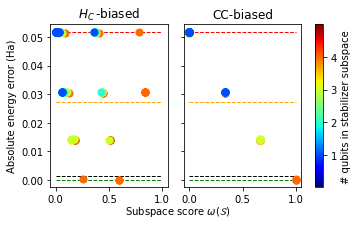

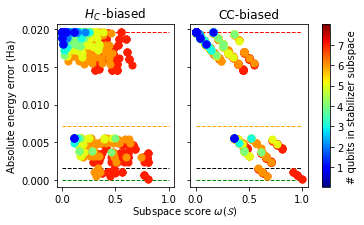

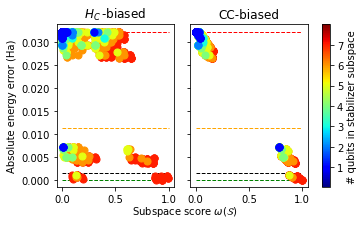

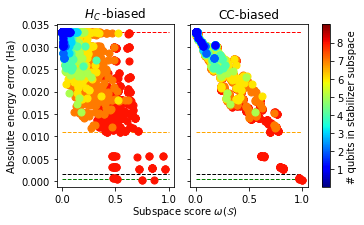

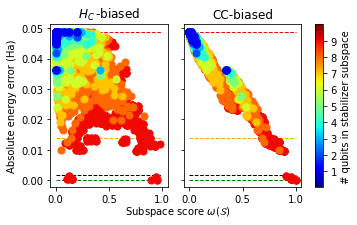

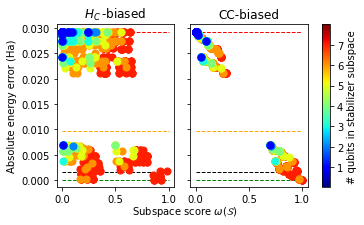

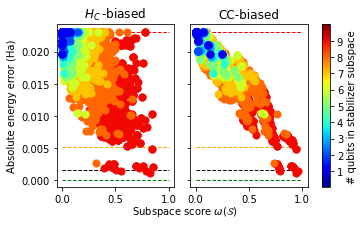

In [9]:
from matplotlib.pyplot import Normalize


for index,speciesname in enumerate(rand_molecules):
    
    fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(5,3),
                           gridspec_kw={'width_ratios': [10, 10, 1]})
        
    data = randomized[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    hf_energy = data['hf_energy']
    mp2_energy = data['mp2_energy']
    ccsd_energy = data['ccsd_energy']
    fci_energy = data['fci_energy']
    ham_ucc_nrg = data['ham_score_ucc_score_cs_energy']
    increments=[]
    
    for n_sim_qubits,results in ham_ucc_nrg.items():
        ratio = int(n_sim_qubits)/n_qubits
        increments.append(ratio)
        c = plt.cm.jet(ratio)
        X_ham, X_ucc, X_nrg = zip(*results)
        X_ham = np.array(X_ham)
        X_ucc = np.array(X_ucc)
        Y_nrg = np.array(X_nrg) - fci_energy
        
        axes[0].scatter(np.square(X_ham),Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
        axes[1].scatter(np.square(X_ucc),Y_nrg,marker='o',color=c,s=50,zorder=1,alpha=1)
    
    def plot_lines(axis):
        axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
        axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
        axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
        axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')
    plot_lines(axes[0])
    plot_lines(axes[1])
    
    keys = list(ham_ucc_nrg.keys())
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                         ax=axes[2], label='# qubits in stabilizer subspace', ticks=increments, fraction=1.2)
    cbar.ax.set_yticklabels(keys)

    axes[0].set_title('$H_{C}\,$-biased')
    axes[1].set_title('CC-biased')
    axes[0].set_ylabel('Absolute energy error (Ha)')
    axes[1].set_xlabel('Subspace score $\omega(\mathcal{S})$')
    axes[1].xaxis.set_label_coords(-0.05,-0.1)
    axes[2].set_visible(False)    
    
    filename = f'plots/{speciesname}_score_vs_energy.png'
    #fig.savefig(filename, dpi=300, bbox_inches='tight')

In [10]:
keys = list(data.keys())
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(), cmap='jet'), 
                     ax=axis, label='# qubits in stabilizer subspace', ticks=increments)#, fraction=0.78)
cbar.ax.set_yticklabels(keys)

axis.set_xlabel('Stabilizer subspace score')
axis.set_ylabel('$\omega(\mathcal{S})$')

axis.hlines(hf_energy-fci_energy, 0, 1, ls='--', lw=1, color='red', zorder=0, label='HF energy')
axis.hlines(mp2_energy-fci_energy, 0, 1, ls='--', lw=1, color='orange', zorder=0, label='MP2 energy')
axis.hlines(ccsd_energy-fci_energy, 0, 1, ls='--', lw=1, color='green', zorder=0, label='CCSD energy')
axis.hlines(0.0016, 0, 1, ls='--', lw=1, color='black', zorder=0, label='Chemical accuracy')

    
c = plt.cm.jet(index/len(plot_mols))
X = np.arange(len(scores))+1
score_axis.plot(X,scores, color=c, marker='+', label=f'{n_qubits_full}q {name}')
score_axis.vlines(scored_1+1, 0, 1, color=c, ls='--', lw=1)

NameError: name 'axis' is not defined

# Plot the small molecules with their CS-VQE errors

In [13]:
import sys
sys.path.append( '../../CS-VQE' )
from utils.cs_vqe_tools_original import *

In [146]:
from symred.chem import MoleculeBuilder
# Set molecule parameters
speciesname = 'CH4_STO-3G_SINGLET'
#print(speciesname in scoring_data)
mol_data = molecule_geometries[speciesname]
if 'name' in mol_data:
    print(mol_data['name'])
    
atoms  = mol_data['atoms']
coords = mol_data['coords']
basis  = mol_data['basis'] #'6-31g' #'cc-pVDZ' #
spin   = 0#mol_data['multiplicity']
charge = mol_data['charge']
geometry = list(zip(atoms, coords))
molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=spin, run_fci=True)

methane
Molecule geometry:
C	0.0	0.0	0.0
H	0.638353	0.638353	0.638353
H	-0.638353	-0.638353	0.638353
H	-0.638353	0.638353	-0.638353
H	0.638353	-0.638353	-0.638353

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -39.72518725776475
MP2 energy:  -39.78339779310938
CCSD energy: -39.80672995849171
FCI energy:  -39.80698697524775


Number of qubits: 18


In [147]:
from symred.projection import QubitTapering, CS_VQE
from symred.symplectic import QuantumState

taper_hamiltonian = QubitTapering(molecule.H_q)

print(f'We are able to taper {taper_hamiltonian.n_taper} qubits from the Hamiltonian.\n')
print('The symmetry generators are\n')
print(taper_hamiltonian.symmetry_generators)
print('\nand may be rotated via a sequence of Clifford pi/2 rotations\n')
print(taper_hamiltonian.stabilizers.stabilizer_rotations)
print('\nonto the single-qubit Pauli operators\n')
print(taper_hamiltonian.stabilizers.rotate_onto_single_qubit_paulis())
hf_array = molecule.H_fermion.hf_comp_basis_state
taper_hamiltonian.stabilizers.update_sector(hf_array)
print(f'\nThe symetry sector corresponding with the reference {hf_array} is {taper_hamiltonian.stabilizers.coeff_vec}')
ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
sor_tap = taper_hamiltonian.taper_it(aux_operator=molecule.SOR_q, ref_state=hf_array)
#sor_tap.coeff_vec/=np.linalg.norm(sor_tap.coeff_vec)
ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
n_taper = taper_hamiltonian.n_taper
tapered_qubits   = taper_hamiltonian.stab_qubit_indices
untapered_qubits = taper_hamiltonian.free_qubit_indices
hf_tapered = taper_hamiltonian.tapered_ref_state

print(f'The tapered Hartree-Fock state is', QuantumState([hf_tapered]))

We are able to taper 2 qubits from the Hamiltonian.

The symmetry generators are

 1 ZIZIZIZIZIZIZIZIZI 
 1 IZIZIZIZIZIZIZIZIZ

and may be rotated via a sequence of Clifford pi/2 rotations

[(1.000+0.000j YIZIZIZIZIZIZIZIZI, None), (1.000+0.000j IYIZIZIZIZIZIZIZIZ, None)]

onto the single-qubit Pauli operators

-1 XIIIIIIIIIIIIIIIII 
-1 IXIIIIIIIIIIIIIIII

The symetry sector corresponding with the reference [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0] is [-1 -1]
The tapered Hartree-Fock state is  1.0000000000 |1111111100000000>


In [148]:
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='legacy')
H = ham_tap.to_dictionary
H_noncon = greedy_dfs(H, cutoff=10)[-1]#cs_vqe.noncontextual_operator.to_dictionary

KeyboardInterrupt: 

In [ ]:
H_noncon = {P:H[P] for P in H_noncon}

In [ ]:
from symred.utils import exact_gs_energy
gs = exact_gs_energy(ham_tap.to_sparse_matrix)[0]
csvqe_approximations_heuristic(H, H_noncon, ham_tap.n_qubits, gs)

In [83]:
legacy_results = {
    'H2O_STO-3G_SINGLET':[0.0488069697761091,
  0.0488069697761091,
  0.04513454582829013,
  0.042323892025947885,
  0.02995329658938317,
  0.024321918999390846,
  0.013476263744422567,
  0.0011377046813549896,
  7.877409866807739e-05,
  5.2677496185538075e-05,
  6.110667527536862e-13],
    'Be_STO-3G_SINGLET': [0.051774631865646015,
  0.03086420431586845,
  0.014216038974156575,
  0.0003265062728363688,
  0.0001759789016357871,
  1.7763568394002505e-14],
    'LiH_STO-3G_SINGLET':[0.019646909485001807,
  0.019646909304649185,
  0.017728060808559043,
  0.0037615656160880917,
  0.001300900609045641,
  0.0007544906269778551,
  0.0002244203971484282,
  0.0001719657090104576,
  1.2434497875801753e-14],
    'HF_STO-3G_SINGLET':[0.032290709283017804,
  0.032290709283003594,
  0.006812108322606036,
  0.004704521989424393,
  0.0008086666160522782,
  0.00040173434993562296,
  1.9912255893927977e-05,
  1.3624774624076963e-05,
  1.1084466677857563e-12],
    'BeH2_STO-3G_SINGLET':[0.033393337994118255,
  0.030345663315117122,
  0.027493524224089683,
  0.027443131499538254,
  0.023483766358953773,
  0.018322604165874168,
  0.011437680683631157,
  0.0003361580107590356,
  0.00022863796765371092,
  -5.329070518200751e-15],
    'NH3_STO-3G_SINGLET':[0.07632848090939603,
  0.07632848090938893,
  0.07555906313677951,
  0.07511680452787317,
  0.06268673127699742,
  0.05743310839041982,
  0.0488375406694459,
  0.046024713470728784,
  0.03393487214785296,
  0.01474661422266621,
  0.009189075699019611,
  0.0001690593012995123,
  0.00010959333877025301,
  -2.7000623958883807e-13]
}

In [149]:
def plot_energy_vs_score(speciesname, energy_axis):
    data_1 = scoring_data_1[speciesname]
    data_2 = scoring_data_2[speciesname]
    Y_energy_2 = legacy_results[speciesname][1:-1]
    n_qubits = data_2['n_qubits_post_taper']
    n_qubits_full = data_2['n_qubits_pre_taper']
    fci_energy = data_2['fci_energy']
    hf_error = data_2['hf_energy'] - fci_energy
    mp2_error = data_2['mp2_energy'] - fci_energy
    ccsd_error = data_2['ccsd_energy'] - fci_energy
    
    X = np.arange(1, n_qubits)
    Y_scores = np.array(data_2['stabilizer_score'])
    Y_energy = np.array(data_2['cs_vqe_energies'])[:15] - fci_energy
    Y_energy_1 = np.array(data_1['cs_vqe_energies'])[:15] - fci_energy
   
    
    energy_axis.hlines(hf_error,  1, X[-1], ls='--', color='red',    label='HF energy')
    energy_axis.hlines(mp2_error, 1, X[-1], ls='--', color='orange', label='MP2 energy')
    energy_axis.hlines(ccsd_error,1, X[-1], ls='--', color='green',  label='CCSD energy')
    energy_axis.hlines(0.0016,    1, X[-1], ls='--', color='black',  label='Chemical accuracy')

    energy_axis.plot(X[:15], Y_energy, color='black', marker='+', label='Truncated CC symmetries')
    energy_axis.plot(X[:len(Y_energy_2)], Y_energy_2, color='black', marker='+', ls='--', label='Greedy-search')  
    energy_axis.set_yscale('log')
    #energy_axis.set_ylim(1e-20, 1)
    
    score_axis = energy_axis.twinx()
    score_axis.plot(X, Y_scores, color='purple', label='CC score', marker='+', alpha=0.3)
    score_axis.set_ylim(0,1)
    
    energy_axis.set_title(speciesname)
    #energy_axis.set_xlabel('Number of qubits in subspace $N-|\mathcal{S}|$')
    #energy_axis.set_ylabel('FCI error [Ha]')
    #score_axis.set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

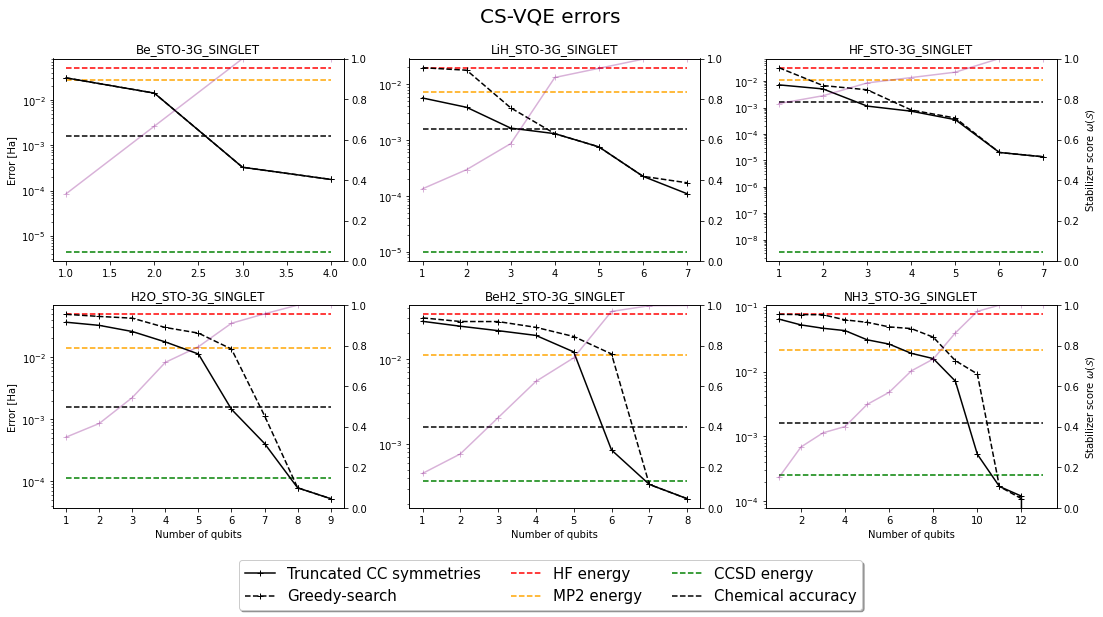

In [150]:
molecules = list(scoring_data_2.keys())
molecules = list(legacy_results.keys())
plot_mols = [mol for mol in molecules if scoring_data_2[mol]['fci_energy'] is not None]
mol_order = sorted([(mol, scoring_data_2[mol]['n_qubits_pre_taper']) for mol in plot_mols], key=lambda x:x[1])
mol_order, qubits = zip(*mol_order)

ncols, nrows = factor_near_square(len(plot_mols))
if ncols<nrows:
    ncols,nrows=nrows,ncols
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))#, sharey=True)

for speciesname, axis in zip(mol_order, fig.get_axes()):
    plot_energy_vs_score(speciesname, axis)

fig.tight_layout()

for i in range(nrows):
    axes[i,0].set_ylabel('Error [Ha]')
for i in range(ncols):
    axes[1,i].set_xlabel('Number of qubits')
fig.get_axes()[-1].set_ylabel('Stabilizer score $\omega(\mathcal{S})$')
fig.get_axes()[-4].set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

handles, labels = axes[1,1].get_legend_handles_labels()
order = list(range(len(handles)))

fig.suptitle('CS-VQE errors', size=20, y=1.05)
fig.legend([handles[i] for i in order],
        [labels[i] for i in order],
            loc="lower center",   # Position of legend
            borderaxespad=0.1,    # Small spacing around legend box
            ncol=3,
            bbox_to_anchor=(0.5, -0.15),
            fancybox=True, 
            shadow=True,
            prop={'size': 15})

plt.show()

In [152]:
fig.savefig('plots/truncated_CC_vs_greedy_search.png', dpi=300, bbox_inches='tight')

In [26]:
original={
    'H2O_STO-3G_SINGLET':7,
    'BeH+_STO-3G_SINGLET':'n/a',
    'LiH_STO-3G_SINGLET':4,
    'HF_STO-3G_SINGLET':4,
    'BeH2_STO-3G_SINGLET':7,
    'Be_STO-3G_SINGLET':3,
    'HCl_STO-3G_SINGLET':4,
    'NH3_STO-3G_SINGLET':11,
    'HCN_STO-3G_SINGLET':'n/a',
    'CH4_STO-3G_SINGLET':12,
    'CH3OH_STO-3G_SINGLET':'n/a',
    'SiH4_STO-3G_SINGLET':'n/a',
    'H2S_STO-3G_SINGLET':7,
    'HOOH_STO-3G_SINGLET':'n/a',
    'O3_STO-3G_SINGLET':'n/a',
    'O2_STO-3G_SINGLET':11
}

In [28]:
chem_acc_scores = []

for speciesname in mol_order:
    data = scoring_data_2[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    fci_energy = data['fci_energy']
    scores = data['stabilizer_score']
    cs_vqe_nrg = np.array(data['cs_vqe_energies'])[:15]-fci_energy
    try:
        index_chem_acc = np.where(cs_vqe_nrg<0.0016)[0][0]
        chem_acc_num_q = index_chem_acc+1
        chem_acc_scores.append(scores[index_chem_acc])
        frmat = speciesname[:speciesname.find('_')]
        orgnl = original[speciesname]
        if orgnl!='n/a':
            print(f'\ce{ {frmat} } & {n_qubits_full} & {n_qubits} & {chem_acc_num_q} & {orgnl} \\\\')
    except:
        pass
    
np.mean(chem_acc_scores)

\ce{'Be'} & 10 & 5 & 3 & 3 \\
\ce{'LiH'} & 12 & 8 & 4 & 4 \\
\ce{'HF'} & 12 & 8 & 3 & 4 \\
\ce{'H2O'} & 14 & 10 & 6 & 7 \\
\ce{'BeH2'} & 14 & 9 & 6 & 7 \\
\ce{'NH3'} & 16 & 14 & 10 & 11 \\
\ce{'CH4'} & 18 & 16 & 13 & 12 \\
\ce{'HCl'} & 20 & 17 & 3 & 4 \\
\ce{'H2S'} & 22 & 18 & 7 & 7 \\


0.926661773391844

# Plot the larger molecule scores for which FCI is too expensive

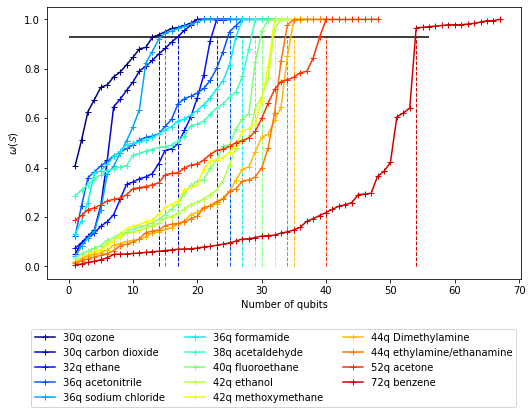

In [11]:
from matplotlib import cm

molecules = list(scoring_data_2.keys())

plot_mols = [mol for mol in molecules if scoring_data_2[mol]['n_qubits_pre_taper'] >=30]
mol_order = sorted([(mol, scoring_data_2[mol]['n_qubits_pre_taper']) for mol in plot_mols], key=lambda x:x[1])
mol_order, qubits = zip(*mol_order)

fig,score_axis = plt.subplots(figsize=(8.5,5))

for index, speciesname in enumerate(mol_order):
    try:
        name = molecule_geometries[speciesname]['name']
    except:
        name = 'Water cc-pVDZ'
    data = scoring_data_2[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    scores = np.array(data['stabilizer_score'])
    scored_1 = np.where(scores>0.93)[0][0]
    
    c = plt.cm.jet(index/len(plot_mols))
    X = np.arange(len(scores))+1
    score_axis.plot(X,scores, color=c, marker='+', label=f'{n_qubits_full}q {name}')
    score_axis.vlines(scored_1+1, 0, 0.93, color=c, ls='--', lw=1)

score_axis.hlines(0.93, 0, 56, color='black')
score_axis.set_xlabel('Number of qubits')
score_axis.set_ylabel('$\omega(\mathcal{S})$')
fig.legend(ncol=3, bbox_to_anchor=(0.9,0))
plt.show()

In [30]:
fig.savefig('plots/large_molecules.png', dpi=300, bbox_inches='tight')

In [61]:
molecules = list(scoring_data_2.keys())
plot_mols = [mol for mol in molecules if scoring_data_2[mol]['n_qubits_pre_taper'] >=30]
mol_order = sorted([(mol, scoring_data_2[mol]['n_qubits_pre_taper']) for mol in plot_mols], key=lambda x:x[1])
mol_order, qubits = zip(*mol_order)

for speciesname in mol_order:
    try:
        name = molecule_geometries[speciesname]['name']
    except:
        name = 'Water cc-pVDZ'
    name = name[0].upper() + name[1:]
    data = scoring_data_2[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    scores = np.array(data['stabilizer_score'])
    scored_93 = np.where(scores>0.93)[0][0]
    scored_99 = np.where(scores>0.99)[0][0] 
    frmat = speciesname[:speciesname.find('_')]
    print(f'{name} & \ce{ {frmat} } & {n_qubits_full} & {n_qubits} & {scored_93} & {scored_99} \\\\')

Ozone & \ce{'O3'} & 30 & 26 & 13 & 19 \\
Carbon dioxide & \ce{'CO2'} & 30 & 26 & 16 & 19 \\
Ethane & \ce{'C2H6'} & 32 & 28 & 22 & 22 \\
Acetonitrile & \ce{'CH3CN'} & 36 & 33 & 24 & 26 \\
Sodium chloride & \ce{'NaCl'} & 36 & 33 & 14 & 20 \\
Formamide & \ce{'CHONH2'} & 36 & 33 & 26 & 26 \\
Acetaldehyde & \ce{'CH3CHO'} & 38 & 35 & 28 & 28 \\
Fluoroethane & \ce{'C2H5F'} & 40 & 37 & 29 & 30 \\
Ethanol & \ce{'CH3CH2OH'} & 42 & 39 & 31 & 32 \\
Methoxymethane & \ce{'CH3OCH3'} & 42 & 38 & 31 & 31 \\
Dimethylamine & \ce{'CH3NHCH3'} & 44 & 41 & 34 & 34 \\
Ethylamine/ethanamine & \ce{'CH3CH2NH2'} & 44 & 41 & 33 & 34 \\
Acetone & \ce{'CH3COCH3'} & 52 & 49 & 39 & 39 \\


In [63]:
molecules = list(scoring_data_1.keys())
plot_mols = [mol for mol in molecules if scoring_data_1[mol]['n_qubits_pre_taper'] >=30]
mol_order = sorted([(mol, scoring_data_1[mol]['n_qubits_pre_taper']) for mol in plot_mols], key=lambda x:x[1])
mol_order, qubits = zip(*mol_order)

for speciesname in mol_order:
    try:
        name = molecule_geometries[speciesname]['name']
    except:
        name = 'Water cc-pVDZ'
    name = name[0].upper() + name[1:]
    data = scoring_data_1[speciesname]
    n_qubits = data['n_qubits_post_taper']
    n_qubits_full = data['n_qubits_pre_taper']
    scores = np.array(data['stabilizer_score'])
    scored_93 = np.where(scores>0.93)[0][0]
    scored_99 = np.where(scores>0.99)[0][0] 
    frmat = speciesname[:speciesname.find('_')]
    print(f'{name} & \ce{ {frmat} } & {n_qubits_full} & {n_qubits} & {scored_93} & {scored_99} \\\\')

Ozone & \ce{'O3'} & 30 & 26 & 14 & 18 \\
Carbon dioxide & \ce{'CO2'} & 30 & 26 & 14 & 19 \\
Ethane & \ce{'C2H6'} & 32 & 28 & 21 & 22 \\
Sodium chloride & \ce{'NaCl'} & 36 & 33 & 13 & 18 \\
Formamide & \ce{'CHONH2'} & 36 & 33 & 26 & 26 \\
Acetonitrile & \ce{'CH3CN'} & 36 & 33 & 24 & 26 \\
Acetaldehyde & \ce{'CH3CHO'} & 38 & 35 & 27 & 28 \\
Fluoroethane & \ce{'C2H5F'} & 40 & 37 & 29 & 30 \\
Methoxymethane & \ce{'CH3OCH3'} & 42 & 38 & 31 & 31 \\
Ethanol & \ce{'CH3CH2OH'} & 42 & 39 & 32 & 32 \\
Ethylamine/ethanamine & \ce{'CH3CH2NH2'} & 44 & 41 & 34 & 34 \\
Dimethylamine & \ce{'CH3NHCH3'} & 44 & 41 & 34 & 34 \\
Water cc-pVDZ & \ce{'H2O'} & 48 & 44 & 34 & 40 \\
Acetone & \ce{'CH3COCH3'} & 52 & 49 & 38 & 39 \\
Isopropyl alcohol & \ce{'CH3CHOHCH3'} & 56 & 54 & 44 & 45 \\


# ref_energy = ccsd_energy

fig,energy_axis = plt.subplots()
X=np.arange(1, n_qubits)

Y_energy=np.array(energies)-ref_energy
energy_axis.plot(X[:0], Y_energy, color='black')
energy_axis.hlines(hf_energy-ref_energy, 1, X[-1], ls='--', color='red', label='HF energy')
energy_axis.hlines(mp2_energy-ref_energy, 1, X[-1], ls='--', color='orange', label='MP2 energy')
energy_axis.hlines(ccsd_energy-ref_energy, 1, X[-1], ls='--', color='green', label='CCSD energy')
#energy_axis.hlines(0.0016, 1, X[-1], ls='--', color='black', label='Chemical accuracy')

#energy_axis.set_ylim(1e-15, 1e-0) 
#energy_axis.set_yscale('log')

score_axis = energy_axis.twinx()
Y_scores=np.array(scores)
score_axis.scatter(X, Y_scores, color='black', marker='+')

#energy_axis.set_xticks(X)

fig.legend(ncol=4)
plt.show()

In [110]:
from scipy.special import comb

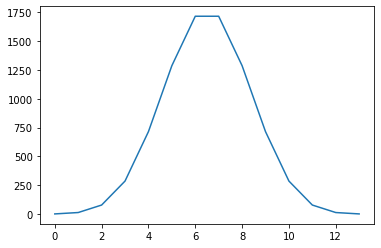

In [128]:
plt.plot([comb(13,x) for x in range(14)])

In [99]:
0.99**2

0.9801